<a href="https://colab.research.google.com/github/tradeasystems/colab_test/blob/master/cart_pole_reinforcement_learning_open_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install gym
!pip install h5py
!pip install keras-rl
!pip install mpld3

     |████████████████████████████████| 40kB 2.8MB/s 
  Created wheel for keras-rl: filename=keras_rl-0.4.2-cp36-none-any.whl size=48379 sha256=d034ad2067397c3f4644a35b231f594ec32831325cd64711d272957b22aa61b5
  Stored in directory: /root/.cache/pip/wheels/7d/4d/84/9254c9f2e8f51865cb0dac8e79da85330c735551d31f73c894
Successfully built keras-rl
     |████████████████████████████████| 798kB 3.4MB/s 
  Created wheel for mpld3: filename=mpld3-0.3-cp36-none-any.whl size=116679 sha256=deb6c5f8c383208d889647dfb7b80f39652f27989c7675ddba2b2daea174e9bb
  Stored in directory: /root/.cache/pip/wheels/c0/47/fb/8a64f89aecfe0059830479308ad42d62e898a3e3cefdf6ba28
Successfully built mpld3


# Cart Pole




In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 8]
import mpld3
mpld3.enable_notebook()



import gym
import gym
from gym import spaces, envs
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd

env = gym.make("CartPole-v1")
# env = gym.make("MountainCar-v0")
episodes=1000

## Random


In [0]:
def RandomLearning(env, episodes):
  reward_list = []
  ave_reward_list = []
  for i in range(episodes):
    observation = env.reset()
    done=False
    rewards=[]
    tot_reward, reward = 0,0
    while done != True:
      # todo UNCOMMENT
#       env.render()
      action = env.action_space.sample() # your agent here (this takes random actions)
      observation, reward, done, info = env.step(action)
      tot_reward += reward
    # Track rewards
    reward_list.append(tot_reward)
    
    if (i+1) % 100 == 0:
        ave_reward = np.mean(reward_list)
        ave_reward_list.append(ave_reward)
        reward_list = []
        
    if (i+1) % 100 == 0:    
        print('Episode {} Average Reward: {}'.format(i+1, ave_reward))
  env.close()
  return ave_reward_list

Episode 100 Average Reward: 22.38
Episode 200 Average Reward: 20.59
Episode 300 Average Reward: 20.65
Episode 400 Average Reward: 22.84
Episode 500 Average Reward: 22.25
Episode 600 Average Reward: 22.54
Episode 700 Average Reward: 23.59
Episode 800 Average Reward: 20.98
Episode 900 Average Reward: 20.94
Episode 1000 Average Reward: 23.55


Text(0.5, 1.0, 'Average Reward vs Episodes')

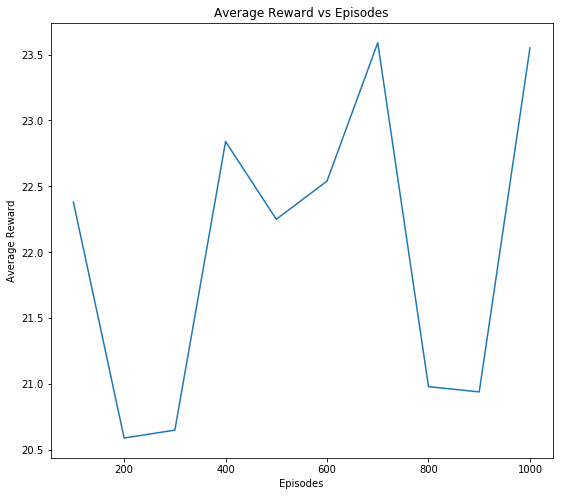

In [3]:
rewards = RandomLearning(env,episodes=episodes)

# Plot Rewards
plt.plot(100*(np.arange(len(rewards)) + 1), rewards)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')
# plt.savefig('rewards.jpg')     
# plt.close()  

## Q Learn


In [0]:
import math
class QLearn():
    def __init__(self,env ,buckets=(1, 1, 6, 12,), episodes=1000, n_win_ticks=195, min_alpha=0.1, epsilon=0.1, discount=1.0, ada_divisor=25, max_env_steps=None, monitor=False):
        self.buckets = buckets # down-scaling feature space to discrete range
        self.n_episodes = episodes # training episodes 
        self.n_win_ticks = n_win_ticks # average ticks over 100 episodes required for win
        self.min_alpha = min_alpha # learning rate
        self.min_epsilon = epsilon # exploration rate
        self.gamma = discount # discount factor
        self.ada_divisor = ada_divisor # only for development purposes

        self.env = env
        if max_env_steps is not None: self.env._max_episode_steps = max_env_steps
        if monitor: self.env = gym.wrappers.Monitor(self.env, 'tmp/cartpole-1', force=True) # record results for upload

        # initialising Q-table
        self.Q = np.zeros(self.buckets + (self.env.action_space.n,))
        

    # Discretizing input space to make Q-table and to reduce dimmensionality
    def discretize(self, obs):
        upper_bounds = [self.env.observation_space.high[0], 0.5, self.env.observation_space.high[2], math.radians(50)]
        lower_bounds = [self.env.observation_space.low[0], -0.5, self.env.observation_space.low[2], -math.radians(50)]
        ratios = [(obs[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) for i in range(len(obs))]
        new_obs = [int(round((self.buckets[i] - 1) * ratios[i])) for i in range(len(obs))]
        new_obs = [min(self.buckets[i] - 1, max(0, new_obs[i])) for i in range(len(obs))]
        return tuple(new_obs)

    # Choosing action based on epsilon-greedy policy
    def choose_action(self, state, epsilon):
        return self.env.action_space.sample() if (np.random.random() <= epsilon) else np.argmax(self.Q[state])

    # Updating Q-value of state-action pair based on the update equation
    def update_q(self, state_old, action, reward, state_new, alpha):
        self.Q[state_old][action] += alpha * (reward + self.gamma * np.max(self.Q[state_new]) - self.Q[state_old][action])

    # Adaptive learning of Exploration Rate
    def get_epsilon(self, t):
        return max(self.min_epsilon, min(1, 1.0 - math.log10((t + 1) / self.ada_divisor)))

    # Adaptive learning of Learning Rate
    def get_alpha(self, t):
        return max(self.min_alpha, min(1.0, 1.0 - math.log10((t + 1) / self.ada_divisor)))

    def run(self):
        reward_list = []
        ave_reward_list = []
        for e in range(self.n_episodes):
            # As states are continuous, discretize them into buckets
            current_state = self.discretize(self.env.reset())

            # Get adaptive learning alpha and epsilon decayed over time
            alpha = self.get_alpha(e)
            epsilon = self.get_epsilon(e)
            done = False
            i = 0
            tot_reward,reward=0,0
            while not done:
                # Render environment
#                 self.env.render()

                # Choose action according to greedy policy and take it
                action = self.choose_action(current_state, epsilon)
                obs, reward, done, _ = self.env.step(action)
                new_state = self.discretize(obs)
                # Update variables
                tot_reward += reward


                # Update Q-Table
                self.update_q(current_state, action, reward, new_state, alpha)
                current_state = new_state
                i += 1
            # Track rewards
            reward_list.append(tot_reward)
            if (e+1) % 100 == 0:
                ave_reward = np.mean(reward_list)
                ave_reward_list.append(ave_reward)
                reward_list = []            
            if (e+1) % 100 == 0:    
                print('Episode {} Average Reward: {}'.format(e+1, ave_reward))
        self.env.close()
        return ave_reward_list

Episode 100 Average Reward: 31.22
Episode 200 Average Reward: 342.29
Episode 300 Average Reward: 496.72
Episode 400 Average Reward: 480.39
Episode 500 Average Reward: 487.33
Episode 600 Average Reward: 494.51
Episode 700 Average Reward: 494.39
Episode 800 Average Reward: 492.57
Episode 900 Average Reward: 493.37
Episode 1000 Average Reward: 496.78


Text(0.5, 1.0, 'Average Reward vs Episodes')

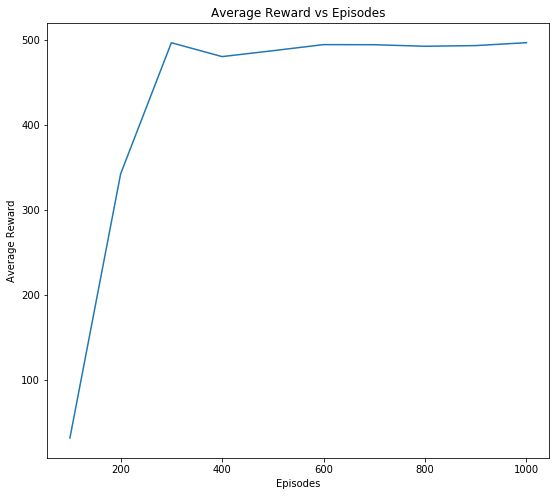

In [5]:
# Run Q-learning algorithm
q_learn = QLearn(env, episodes=episodes)
rewards = q_learn.run()

# Plot Rewards
plt.plot(100*(np.arange(len(rewards)) + 1), rewards)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')
# plt.savefig('rewards.jpg')     
# plt.close()  

## Deep RL

In [6]:

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory


def DeepReinforcementLearning(env,episodes, seq_memory_limit=50000,warmup_steps=100, target_model_update=1e-2, optimizer=Adam(lr=1e-3),metrics=['mae']):
  ## create model -> DQNSolver
  nb_actions = env.action_space.n
  model = Sequential()
  model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
  model.add(Dense(16))
  model.add(Activation('relu'))
  model.add(Dense(nb_actions))
  model.add(Activation('linear'))
  # print(model.summary())

  ## train model
  policy = EpsGreedyQPolicy()
  memory = SequentialMemory(limit=seq_memory_limit, window_length=1)
  dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=warmup_steps,
  target_model_update=target_model_update, policy=policy)
  dqn.compile(optimizer=optimizer, metrics=metrics)
  # Okay, now it's time to learn something! We visualize the training here for show, but this slows down training quite a lot. 
  # dqn.fit(env, nb_steps=5000, visualize=True, verbose=2)
  history = dqn.fit(env, nb_steps=episodes, visualize=False, verbose=2)
  return dqn,history




Using TensorFlow backend.


In [7]:
### need much more iterations!
model,history=DeepReinforcementLearning(env=env,episodes=episodes*50,metrics=['mse'])







Training for 50000 steps ...
     9/50000: episode: 1, duration: 0.153s, episode steps: 9, steps per second: 59, episode reward: 9.000, mean reward: 1.000 [1.000, 1.000], mean action: 1.000 [1.000, 1.000], mean observation: -0.116 [-2.763, 1.787], loss: --, mean_squared_error: --, mean_q: --
    21/50000: episode: 2, duration: 0.006s, episode steps: 12, steps per second: 2025, episode reward: 12.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.917 [0.000, 1.000], mean observation: -0.117 [-3.035, 1.919], loss: --, mean_squared_error: --, mean_q: --
    54/50000: episode: 3, duration: 0.015s, episode steps: 33, steps per second: 2162, episode reward: 33.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.667 [0.000, 1.000], mean observation: -0.042 [-3.227, 2.145], loss: --, mean_squared_error: --, mean_q: --
    65/50000: episode: 4, duration: 0.005s, episode steps: 11, steps per second: 2006, episode reward: 11.000, mean reward: 1.000 [1.000, 1.000], mean action: 0.909 

Text(0.5, 1.0, 'Reward vs Episodes')

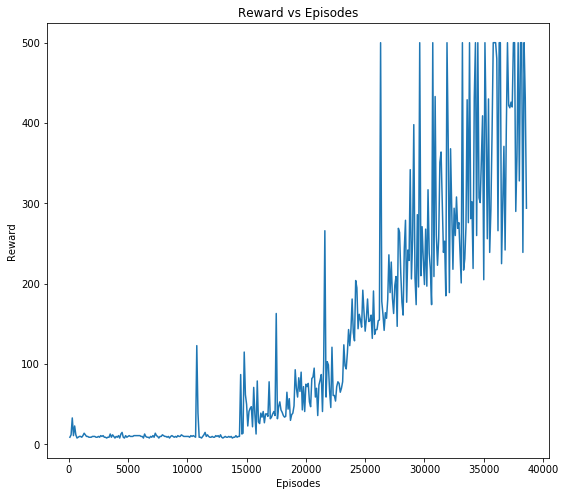

In [10]:
rewards =history.history['episode_reward']
		 
# Plot Rewards
plt.plot(100*(np.arange(len(rewards)) + 1), rewards)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Reward vs Episodes')

In [9]:
model.test(env, nb_episodes=25, visualize=False)


Testing for 25 episodes ...
Episode 1: reward: 470.000, steps: 470
Episode 2: reward: 348.000, steps: 348
Episode 3: reward: 428.000, steps: 428
Episode 4: reward: 230.000, steps: 230
Episode 5: reward: 347.000, steps: 347
Episode 6: reward: 410.000, steps: 410
Episode 7: reward: 463.000, steps: 463
Episode 8: reward: 500.000, steps: 500
Episode 9: reward: 273.000, steps: 273
Episode 10: reward: 364.000, steps: 364
Episode 11: reward: 500.000, steps: 500
Episode 12: reward: 442.000, steps: 442
Episode 13: reward: 463.000, steps: 463
Episode 14: reward: 500.000, steps: 500
Episode 15: reward: 372.000, steps: 372
Episode 16: reward: 500.000, steps: 500
Episode 17: reward: 500.000, steps: 500
Episode 18: reward: 363.000, steps: 363
Episode 19: reward: 435.000, steps: 435
Episode 20: reward: 500.000, steps: 500
Episode 21: reward: 346.000, steps: 346
Episode 22: reward: 500.000, steps: 500
Episode 23: reward: 500.000, steps: 500
Episode 24: reward: 500.000, steps: 500
Episode 25: reward: 4